Step 1: Install Required Libraries

In [1]:
pip install imbalanced-learn

Step 2: Import Required Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
import xgboost as xgb # Import xgboost
from xgboost import XGBClassifier # Import XGBClassifier

from imblearn.over_sampling import SMOTE

# For displaying DataFrames nicely in Colab
from IPython.display import display

Step 3: Upload Your Training Dataset

In [6]:
# Step 3: Upload Your Dataset
from google.colab import files
uploaded = files.upload()

Saving after_dropping_unique_data_containing_features.csv to after_dropping_unique_data_containing_features (1).csv


Step 4: Load and Preprocess the Data

In [7]:
# Step 4: Load and Preprocess the Data (Including Feature Selection)
import io
import pandas as pd # Explicitly import pandas again for clarity in this step, although already imported

# Check if 'uploaded' is defined from the previous step
if 'uploaded' not in locals():
    print("Error: No file uploaded in Step 3. Please run Step 3 first.")
    processing_successful = False # Ensure subsequent steps are skipped
else:
    # Get the uploaded file name (assuming only one file)
    try:
        filename = next(iter(uploaded))
        print(f'Uploaded file: {filename}')

        # Read the uploaded CSV data into a pandas DataFrame
        df = pd.read_csv(io.BytesIO(uploaded[filename]))

        # --- DIAGNOSTIC PRINT ---
        print(f"\nColumns found in the dataset: {df.columns.tolist()}")
        # --- END DIAGNOSTIC PRINT ---

        # --- Data Cleaning ---
        # Use a variable for the label column name for clarity
        # Correct column name as discussed ('Lable' without leading space)
        # *** IMPORTANT: Verify ' Label' exactly matches your column name, including spaces! ***
        label_column = 'Label'

        # Check if the label column exists before proceeding
        if label_column not in df.columns:
            print(f"Error: The required '{label_column}' column was not found in the raw dataset.")
            print(f"Available columns are: {df.columns.tolist()}")
            processing_successful = False
            print(f"\nPreprocessing skipped due to missing '{label_column}' column.")
        else:
             # --- DIAGNOSTIC PRINT ---
            print(f"\nLabel distribution BEFORE dropping missing values:\n{df[label_column].value_counts()}")
            # --- END DIAGNOSTIC PRINT ---

            # Drop rows with missing values
            initial_rows = df.shape[0]
            df.dropna(inplace=True)
            rows_after_dropna = df.shape[0]
            print(f"\nShape after dropping missing values: {df.shape} ({initial_rows - rows_after_dropna} rows dropped)")

             # --- DIAGNOSTIC PRINT ---
            print(f"Label distribution AFTER dropping missing values:\n{df[label_column].value_counts()}")
            # --- END DIAGNOSTIC PRINT ---


            # --- Convert 'Lable' column to binary ---
            # Assuming 'BENIGN' is the label for normal traffic
            # Use .loc to avoid SettingWithCopyWarning
            # Ensure you check for potential whitespace issues around 'BENIGN' if needed
            # *** IMPORTANT: Verify 'BENIGN' exactly matches the normal class value in your data! ***
            df.loc[:, label_column] = df[label_column].apply(lambda x: 0 if str(x).strip() == 'BENIGN' else 1) # Added strip() and str() for robustness
            print(f"'{label_column}' column successfully converted to binary (0: BENIGN, 1: Attack).")

            # --- DIAGNOSTIC PRINT ---
            print(f"Label distribution AFTER binary conversion:\n{df[label_column].value_counts()}")
            # --- END DIAGNOSTIC PRINT ---

            # --- Feature Selection ---
            selected_features = [
                'Destination Port',
                'Total Length of Fwd Packets',
                'Fwd Packet Length Max',
                'Fwd Packet Length Mean',
                'Bwd Packet Length Max',
                'Bwd Packet Length Mean',
                'Max Packet Length',
                'Packet Length Mean',
                'Packet Length Std',
                'Packet Length Variance',
                'Average Packet Size',
                'Avg Bwd Segment Size',
                'Subflow Fwd Bytes',
                'Init_Win_bytes_forward',
                'Init_Win_bytes_backward'
            ]

            # Select only the defined features and the 'Lable' column
            # Ensure all selected_features are present in the dataframe before selection
            features_to_select = [f for f in selected_features if f in df.columns]
            if len(features_to_select) != len(selected_features):
                missing_features = [f for f in selected_features if f not in df.columns]
                print(f"Warning: The following selected features were not found in the dataset and will be skipped: {missing_features}")
                # Decide whether to proceed with only available features or stop
                # For now, we proceed with available features.

            # Ensure the label column is added only if it exists and was processed
            if label_column in df.columns:
                # Check if the label column still has data after potential feature filtering
                if df[label_column].isnull().any(): # This shouldn't happen after dropna, but double-check
                    print(f"Error: The '{label_column}' column contains missing values after preprocessing.")
                    processing_successful = False
                else:
                     # Select the features and the label
                    # Make sure we don't select the label_column twice if it's accidentally in selected_features
                    cols_for_selection = [col for col in features_to_select if col != label_column] + [label_column]
                    df_selected = df[cols_for_selection].copy()


                    # --- IMPORTANT CHECK BEFORE SPLITTING ---
                    # Check if the 'Lable' column in the selected dataframe has more than one unique value
                    unique_classes = df_selected[label_column].nunique()
                    if unique_classes <= 1:
                        print(f"\nError: The '{label_column}' column contains only {unique_classes} unique class(es) after preprocessing and feature selection.")
                        print(f"Unique values in '{label_column}': {df_selected[label_column].unique()}")
                        print("Cannot proceed with train-test split or SMOTE as they require at least two classes.")
                        print("Please check your input data and preprocessing steps (especially handling of missing values).")
                        processing_successful = False # Set flag to prevent subsequent steps
                    else:
                        processing_successful = True # Set flag indicating success if check passes
                        # Split features and labels
                        X = df_selected.drop(label_column, axis=1)
                        y = df_selected[label_column]

                        print("\nData loaded and preprocessed.")
                        print(f"Selected features used: {X.columns.tolist()}")
                        print(f"Shape of features (X): {X.shape}")
                        print(f"Shape of labels (y): {y.shape}")
                        # --- DIAGNOSTIC PRINT ---
                        print(f"Label distribution in y (used for split):\n{y.value_counts()}")
                        # --- END DIAGNOSTIC PRINT ---
            else:
                # This case should theoretically be caught by the first check, but included for robustness
                print(f"\nError: The '{label_column}' column was somehow lost during preprocessing.")
                processing_successful = False

    except FileNotFoundError:
        print("\nError: Uploaded file not found. Please ensure the file was uploaded successfully in Step 3.")
        processing_successful = False
    except Exception as e:
        print(f"\nAn unexpected error occurred during Step 4: {e}")
        processing_successful = False


# The subsequent cells (Step 5, 6, 7 etc.) already have checks like `if 'X' in locals() and 'y' in locals():`
# and `if 'X_train_scaled' in locals() and 'y_train' in locals():`
# These checks will now rely on the `processing_successful` logic effectively,
# preventing them from running if the label column check fails in Step 4.
# Also, explicitly set X and y to None if processing wasn't successful to be safe,
# although the `locals()` checks handle this.
if not processing_successful:
    X = None
    y = None
    # Also set train/test/scaled variables to None to be absolutely sure subsequent steps fail gracefully
    # (though the `locals()` checks should catch this)
    X_train, X_test, y_train, y_test = None, None, None, None
    X_train_scaled, X_test_scaled = None, None

Uploaded file: after_dropping_unique_data_containing_features (1).csv

Columns found in the dataset: ['Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Cou

Step 5: Train-Test Split

In [8]:
# Step 5: Train-Test Split

# Check if data processing was successful in the previous step (Step 4)
# Also check if X and y were created and are not None
if ('processing_successful' in locals() and processing_successful) and \
   ('X' in locals() and X is not None) and \
   ('y' in locals() and y is not None):

    # Split data into 80% training and 20% testing set
    # random_state ensures reproducibility of the split
    # stratify=y ensures that the proportion of classes (BENIGN/Attack) is the same in both train and test sets, important for imbalanced data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTrain-Test Split performed:")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    print(f"Training label distribution:\n{y_train.value_counts()}")
    print(f"Testing label distribution:\n{y_test.value_counts()}")
else:
    # This message is printed if Step 4 failed or X/y are None
    print("\nSkipping Train-Test Split: Data preprocessing in Step 4 was not successful or required data (X, y) is missing/None.")
    print("Please review the output of Step 4 to identify the issue.")

# It's good practice to also set X_train, etc. to None if this step is skipped
# to prevent downstream errors, although the checks in subsequent steps should handle this.
if 'X_train' not in locals():
    X_train, X_test, y_train, y_test = None, None, None, None


Train-Test Split performed:
Training set shape: (327200, 10)
Testing set shape: (81800, 10)
Training label distribution:
Label
1    321319
0      5881
Name: count, dtype: int64
Testing label distribution:
Label
1    80330
0     1470
Name: count, dtype: int64


Step 6: Feature Scaling

In [9]:
# Step 6: Feature Scaling
scaler = StandardScaler() # Initialize the scaler

# Check if X_train and X_test were created in the previous step (Step 5)
if 'X_train' in locals() and 'X_test' in locals():
    # Fit the scaler ONLY on the training data to learn the mean and std dev.
    # Then transform BOTH training and testing data using the learned parameters.
    # This prevents data leakage from the test set into the scaling process.
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("\nFeature Scaling applied using StandardScaler.")
else:
    # This message is printed if X_train or X_test were not created in Step 5
    print("\nSkipping Feature Scaling: Training and testing data not found. Please ensure Step 5 ran successfully.")


Feature Scaling applied using StandardScaler.


Step 7: SMOTE

In [10]:
# Step 7: Handle Class Imbalance Using SMOTE
print("\nApplying SMOTE to the training data...")

# Add a check to ensure X_train_scaled and y_train exist before proceeding
if 'X_train_scaled' in locals() and 'y_train' in locals():

    # --- Suggested Change: Ensure y_train is of integer type ---
    # Cast y_train to a standard integer type to ensure it's recognized as classification labels
    try:
        y_train = y_train.astype(int)
        print("Successfully cast y_train to integer type.")
    except ValueError as e:
        print(f"Error casting y_train to int: {e}")
        print("SMOTE may fail if y_train contains non-integer values.")
        # Decide whether to stop here or try SMOTE anyway
        # For robustness, we might add another check or skip SMOTE

    # --- End Suggested Change ---

    smote = SMOTE(random_state=42)
    # THIS IS THE LINE THAT FAILED BEFORE because y_train had only one class.
    # Now that Step 4 worked correctly, y_train should have at least two classes,
    # and this line should execute without the ValueError.
    # With the added casting, the 'Unknown label type' error should also be resolved
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    print(f"Original training set shape: {X_train_scaled.shape}")
    print(f"Training set shape after SMOTE: {X_train_smote.shape}")
    print(f"Training label distribution after SMOTE:\n{y_train_smote.value_counts()}")
else:
    # Print message if prerequisites are missing
    print("\nSkipping SMOTE: Scaled training data (X_train_scaled) or training labels (y_train) not found.")
    print("Please ensure Step 5 (Train-Test Split) and Step 6 (Feature Scaling) ran successfully.")


Applying SMOTE to the training data...
Successfully cast y_train to integer type.
Original training set shape: (327200, 10)
Training set shape after SMOTE: (642638, 10)
Training label distribution after SMOTE:
Label
1    321319
0    321319
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import GridSearchCV

Step 8:Train ML Models

In [12]:
# Step 8: Train ML Models
print("\n--- Training Models ---")

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Passive Aggressive': PassiveAggressiveClassifier(max_iter=1000, random_state=42, early_stopping=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

trained_models = {}
predictions = {}
probabilities = {} # To store probabilities for ROC curve

# Iterate through the models for training and prediction
for name, model in models.items():
    print(f"Training {name} model...")
    # Check if SMOTE was successful before fitting models
    if 'X_train_smote' in locals() and 'y_train_smote' in locals():
        model.fit(X_train_smote, y_train_smote)
        print("Done.")

        # Check if the model was successfully trained and if test data exists before predicting
        if 'X_test_scaled' in locals() or 'X_test_scaled' in globals():
             trained_models[name] = model # Store the trained model
             predictions[name] = trained_models[name].predict(X_test_scaled)

             # Get probabilities or decision function scores for ROC Curve
             try:
                 # Check if the model has predict_proba (needed for roc_auc)
                 if hasattr(trained_models[name], 'predict_proba'):
                      probabilities[name] = trained_models[name].predict_proba(X_test_scaled)[:, 1]
                 elif hasattr(trained_models[name], 'decision_function'):
                     # For models without predict_proba, use decision_function
                     score = trained_models[name].decision_function(X_test_scaled)
                     # Simple scaling to [0, 1] range - note: this is not true probability
                     # Check if score is multi-dimensional (e.g., from Passive Aggressive)
                     if score.ndim > 1:
                         # Assuming binary classification, take the score for the positive class (index 1)
                         probabilities[name] = score[:, 1]
                     else:
                         probabilities[name] = (score - score.min()) / (score.max() - score.min())
                     print(f"Note: Using scaled decision function for {name}'s ROC curve.")
                 else:
                     print(f"Warning: Could not get probabilities or decision function for {name}. ROC curve cannot be generated.")
                     probabilities[name] = None # Indicate no probability data available

             except Exception as e:
                 print(f"An error occurred while getting probabilities for {name}: {e}")
                 probabilities[name] = None

        else:
             print(f"Skipping prediction for {name}: Test data (X_test_scaled) not available.")

    else:
         print(f"Skipping training and prediction for {name}: SMOTE data not available.")


print("\nAll models trained (or skipped if data was unavailable).")


--- Training Models ---
Training Decision Tree model...


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Done.
Training Random Forest model...
Done.
Training Passive Aggressive model...
Done.
Note: Using scaled decision function for Passive Aggressive's ROC curve.
Training XGBoost model...
Done.

All models trained (or skipped if data was unavailable).


Step 9: Evaluate Models

In [13]:
# Step 9: Evaluate Models (Calculate Metrics)
print("\n--- Evaluating Models ---")

metrics_summary = {}

# --- Suggested Change: Ensure y_test is of integer type ---
# Cast y_test to a standard integer type to ensure compatibility with classification metrics
try:
    # Check if y_test exists before attempting to cast
    if 'y_test' in locals() or 'y_test' in globals():
        y_test = y_test.astype(int)
        print("Successfully cast y_test to integer type for evaluation.")
    else:
        print("Warning: y_test not found. Skipping integer cast.")
except ValueError as e:
    print(f"Error casting y_test to int: {e}")
    print("Evaluation metrics may fail if y_test contains non-integer values.")
# --- End Suggested Change ---


for name in models.keys():
    if name in predictions:
        y_pred = predictions[name]

        # Ensure y_pred is also of integer type for consistency, although typically
        # model.predict() returns integer numpy arrays.
        try:
            y_pred = y_pred.astype(int)
        except ValueError as e:
             print(f"Warning: Error casting y_pred for {name} to int: {e}")


        # Now y_test and y_pred should be compatible integer types
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Calculate AUC if probabilities are available
        auc_score = None
        if name in probabilities and probabilities[name] is not None:
            try:
                 # roc_auc_score also benefits from y_true being integer
                 auc_score = roc_auc_score(y_test, probabilities[name])
            except ValueError:
                 print(f"Could not calculate AUC for {name} (check for single class in y_true or y_score).")
            except Exception as e:
                 print(f"An error occurred while calculating AUC for {name}: {e}")


        metrics_summary[name] = {
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'AUC': auc_score # Add AUC to the summary
        }

        print(f"\nMetrics for {name}:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall: {rec:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        if auc_score is not None:
            print(f"  AUC: {auc_score:.4f}")

    else:
        print(f"\nSkipping evaluation for {name}: Predictions not found.")


# Display metrics in a table
metrics_df = pd.DataFrame(metrics_summary).T
print("\n--- Performance Metrics Summary (on the test set) ---")
display(metrics_df.round(4))


--- Evaluating Models ---
Successfully cast y_test to integer type for evaluation.

Metrics for Decision Tree:
  Accuracy: 0.9776
  Precision: 0.9947
  Recall: 0.9824
  F1 Score: 0.9885
  AUC: 0.8988

Metrics for Random Forest:
  Accuracy: 0.9785
  Precision: 0.9947
  Recall: 0.9833
  F1 Score: 0.9890
  AUC: 0.9014

Metrics for Passive Aggressive:
  Accuracy: 0.8165
  Precision: 0.9997
  Recall: 0.8134
  F1 Score: 0.8970
  AUC: 0.9512

Metrics for XGBoost:
  Accuracy: 0.8895
  Precision: 0.9974
  Recall: 0.8898
  F1 Score: 0.9406
  AUC: 0.9706

--- Performance Metrics Summary (on the test set) ---


,Accuracy,Precision,Recall,F1 Score,AUC
Decision Tree,0.9776,0.9947,0.9824,0.9885,0.8988
Random Forest,0.9785,0.9947,0.9833,0.9890,0.9014
Passive Aggressive,0.8165,0.9997,0.8134,0.8970,0.9512
XGBoost,0.8895,0.9974,0.8898,0.9406,0.9706


Step 10: Bar Graphs


--- Bar Graph of Evaluation Metrics ---


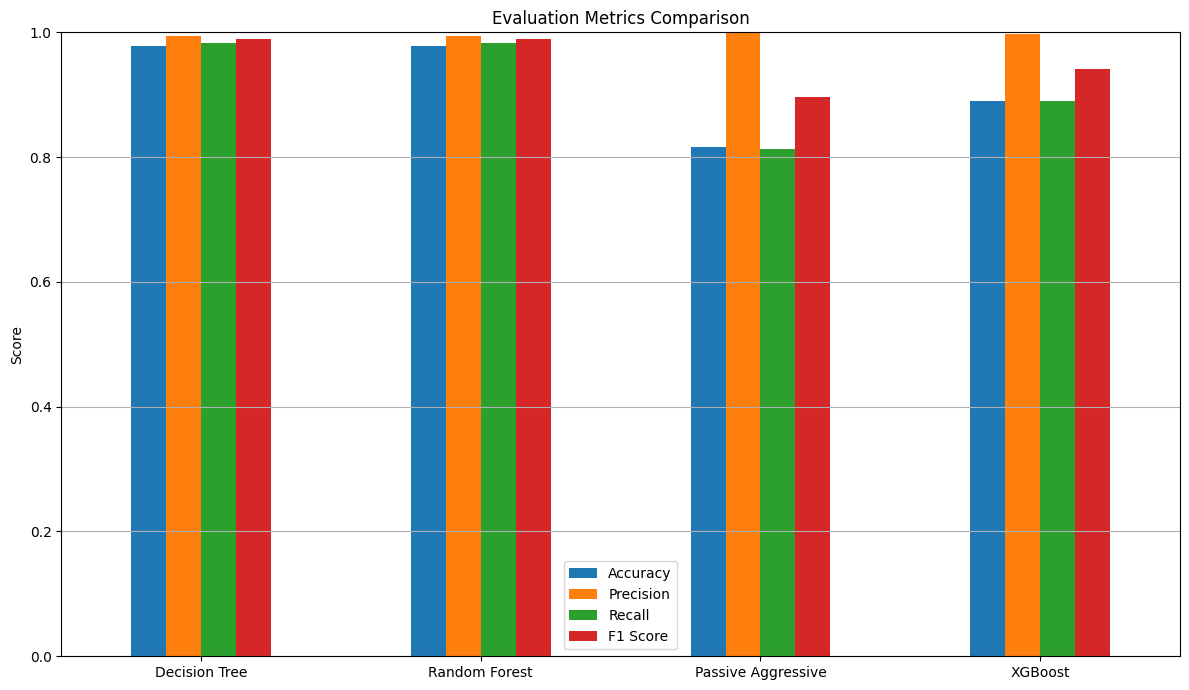

In [14]:
# Step 10: Visualize Evaluation Metrics (Bar Graph)
print("\n--- Bar Graph of Evaluation Metrics ---")

if 'metrics_df' in locals() or 'metrics_df' in globals():
    # Remove AUC column for the bar plot as its scale is different
    metrics_for_plot = metrics_df.drop(columns=['AUC'], errors='ignore')

    metrics_for_plot.plot(kind='bar', figsize=(12, 7))
    plt.title('Evaluation Metrics Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True, axis='y')
    plt.xticks(rotation=0)
    plt.legend(loc='best')
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
else:
    print("Metrics DataFrame (metrics_df) not found. Please ensure Step 9 was run.")

Step 11: Confusion Matrices


--- Confusion Matrices ---


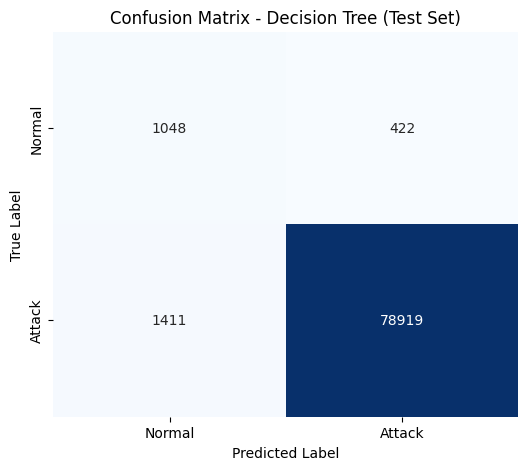

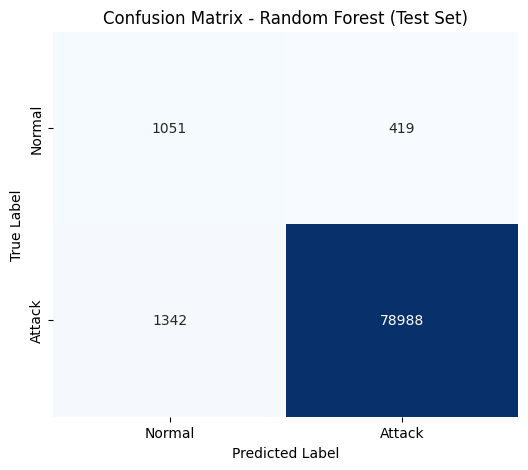

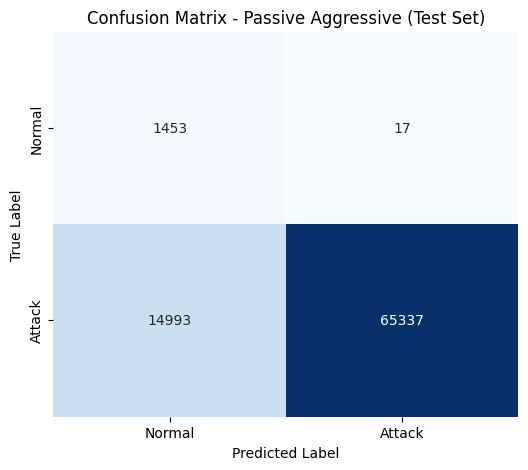

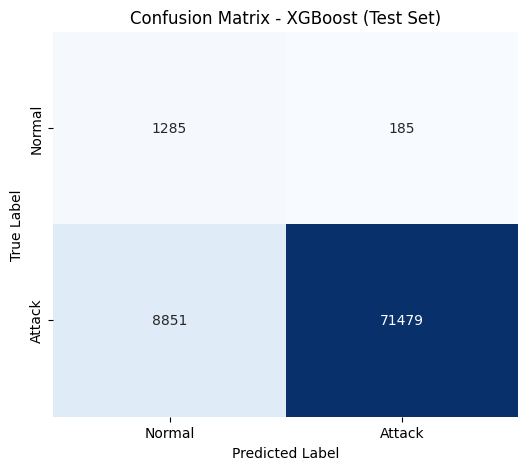

In [15]:
# Step 11: Visualize Confusion Matrices
print("\n--- Confusion Matrices ---")

for name in trained_models.keys():
    if name in predictions:
        y_pred = predictions[name]
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
        plt.title(f'Confusion Matrix - {name} (Test Set)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    else:
        print(f"\nSkipping Confusion Matrix for {name}: Predictions not found.")

Step 12: ROC Curves


--- ROC Curves ---


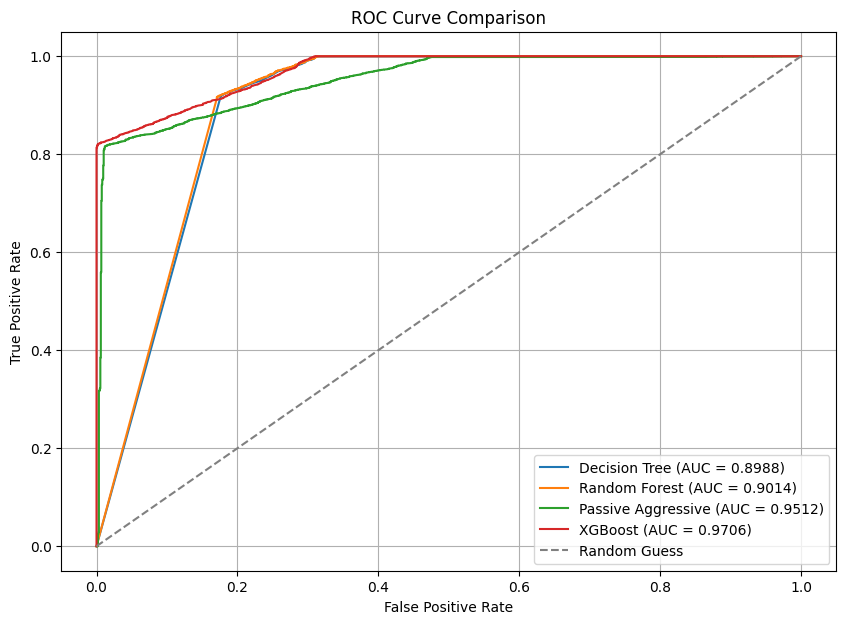

In [16]:
# Step 12: Visualize ROC Curves
print("\n--- ROC Curves ---")

plt.figure(figsize=(10, 7))

for name in models.keys():
    if name in probabilities and probabilities[name] is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test, probabilities[name])
            auc_score = roc_auc_score(y_test, probabilities[name])
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')
        except Exception as e:
             print(f"Could not plot ROC curve for {name}: {e}")

    else:
        print(f"Skipping ROC curve for {name}: Probabilities/Decision Function scores not available.")


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

Step 13: Individual Prediction

In [17]:
# Step 13: Individual Prediction
print("\n--- Make an Individual Prediction ---")

# Choose which model to use for individual prediction
# You can change this to 'Decision Tree', 'Random Forest', 'Passive Aggressive', or 'XGBoost'
chosen_model_name = 'XGBoost' # Example: Using XGBoost

# Ensure the chosen model and scaler are available from previous steps
if ('trained_models' in locals() or 'trained_models' in globals()) and \
   (chosen_model_name in trained_models):

    model_for_prediction = trained_models[chosen_model_name]

    if 'scaler' in locals() or 'scaler' in globals():
        scaler_for_prediction = scaler

        print(f"\nUsing the trained {chosen_model_name} model for individual prediction.")
        print("Please enter the values for the following features:")

        # Define the specific list of features to ask for.
        # This MUST match the order and names of the features used during training (X.columns).
        # It's best to get this list directly from the X DataFrame if available.
        specific_features = []
        if 'X' in locals() or 'X' in globals():
            specific_features = X.columns.tolist()
            print(f"Expecting values for {len(specific_features)} features.")
        else:
            print("Warning: Original features (X) DataFrame not found. Cannot list expected features.")
            print("Falling back to a predefined list. Ensure this list matches your trained features!")
            # Fallback list - ensure this is correct if X is not available
            specific_features = [
                'Destination Port',
                'Total Length of Fwd Packets',
                'Fwd Packet Length Max',
                'Fwd Packet Length Mean',
                'Bwd Packet Length Max',
                'Bwd Packet Length Mean',
                'Max Packet Length',
                'Packet Length Mean',
                'Packet Length Std',
                'Packet Length Variance',
                'Average Packet Size',
                'Avg Bwd Segment Size',
                'Subflow Fwd Bytes',
                'Init_Win_bytes_forward',
                'Init_Win_bytes_backward'
            ]


        if specific_features: # Proceed only if we have a list of features
            input_values = {}
            valid_input = True

            # Prompt the user for each feature value
            for feature in specific_features:
                try:
                    value_str = input(f"Enter value for '{feature}': ")
                    # Handle potential empty or invalid input more gracefully
                    if value_str.strip() == '':
                        print(f"Warning: Empty input for '{feature}'. Using 0 or skipping.")
                        # Decide how to handle missing input: assign 0, NaN, or skip?
                        # Assigning 0 might be okay for some features, but not all.
                        # Let's require a number for now.
                        print("Invalid input: Input cannot be empty.")
                        valid_input = False
                        break
                    value = float(value_str)
                    input_values[feature] = value
                except ValueError:
                    print(f"Invalid input for '{feature}'. Please enter a number.")
                    valid_input = False
                    break # Exit loop on invalid input

            # Proceed only if all inputs were valid
            if valid_input:
                # Create a DataFrame from the input values
                # Important: Ensure the DataFrame has the same columns as the training data
                # and in the same order. Using a single row list and specifying columns is safer.
                try:
                    input_df = pd.DataFrame([list(input_values.values())], columns=specific_features)

                    # Scale the input data using the scaler trained on the training data (from Step 6)
                    input_scaled = scaler_for_prediction.transform(input_df)

                    # Make the prediction
                    individual_prediction = model_for_prediction.predict(input_scaled)

                    # Map the numerical prediction to the class label
                    prediction_map = {0: 'Normal (BENIGN)', 1: 'Attack'}
                    predicted_class = prediction_map.get(individual_prediction[0], f'Unknown ({individual_prediction[0]})')

                    print(f"\nIndividual Prediction: {predicted_class}")

                    # Optional: Get prediction probability if the model supports it
                    if hasattr(model_for_prediction, 'predict_proba'):
                        prediction_proba = model_for_prediction.predict_proba(input_scaled)
                        # Assuming binary classification, get probability of the positive class (index 1)
                        print(f"Prediction Probability (Class 1 - Attack): {prediction_proba[0][1]:.4f}")
                    elif hasattr(model_for_prediction, 'decision_function'):
                        # For models without predict_proba, use decision_function (less intuitive as probability)
                         decision_score = model_for_prediction.decision_function(input_scaled)
                         print(f"Decision Function Score: {decision_score[0]:.4f}")


                except KeyError as e:
                    print(f"\nError creating input DataFrame: Missing feature '{e}'.")
                    print("Ensure the features you entered values for match the features the model was trained on.")
                except ValueError as e:
                     print(f"\nError during scaling or prediction: {e}")
                     print("This might happen if the input values are significantly different from training data range.")
                except Exception as e:
                    print(f"\nAn unexpected error occurred during individual prediction: {e}")


            else:
                print("\nIndividual prediction cancelled due to invalid input.")

        else:
            print("\nError: Could not determine features for input. Cannot proceed with individual prediction.")

    else:
        print("\nError: StandardScaler not found. Please ensure Step 6 was run successfully.")
else:
     # Adjusted the message slightly for clarity
    if 'trained_models' not in locals() and 'trained_models' not in globals():
         print("\nError: Trained models (trained_models) not found. Please ensure Step 8 was run successfully.")
    elif chosen_model_name not in trained_models:
         print(f"\nError: Chosen model '{chosen_model_name}' not found in trained_models.")
         print(f"Available models are: {list(trained_models.keys()) if trained_models else 'None'}")


--- Make an Individual Prediction ---

Using the trained XGBoost model for individual prediction.
Please enter the values for the following features:
Expecting values for 10 features.
Enter value for 'Destination Port': 4444
Enter value for 'Fwd Packet Length Max': 1500
Enter value for 'Fwd Packet Length Mean': 700
Enter value for 'Bwd Packet Length Max': 1200
Enter value for 'Bwd Packet Length Mean': 650
Enter value for 'Packet Length Mean': 800
Enter value for 'Packet Length Std': 300
Enter value for 'Packet Length Variance': 90000
Enter value for 'Avg Bwd Segment Size': 600
Enter value for 'Subflow Fwd Bytes': 500000

Individual Prediction: Attack
Prediction Probability (Class 1 - Attack): 0.9970
